In [1]:
# imports
from utils import *
from models import *

In [147]:
def neg_days_to_years(df:pd.DataFrame):
    # Converts all days columns to positive values with a years unit
    # give dataframe in as a copy so it doesn't overwrite the original
    for col in df:
        if "DAYS" in col:
            df[[col]] = -df[col]/365
            print(col, (df[col].dropna()>=0).all())
    return df

df = neg_days_to_years(train_data.copy())
'''
DAYS_BIRTH True
DAYS_EMPLOYED False -> need to deal with anomalies first
DAYS_REGISTRATION True
DAYS_ID_PUBLISH True
DAYS_LAST_PHONE_CHANGE False -> gotta drop na's
'''

DAYS_BIRTH True
DAYS_EMPLOYED False
DAYS_REGISTRATION True
DAYS_ID_PUBLISH True
DAYS_LAST_PHONE_CHANGE True


'\nDAYS_BIRTH True\nDAYS_EMPLOYED False -> need to deal with anomalies first\nDAYS_REGISTRATION True\nDAYS_ID_PUBLISH True\nDAYS_LAST_PHONE_CHANGE False -> \n'

In [111]:
from scipy.stats import boxcox

def box_cox_transform(df:pd.DataFrame, cols= None):
    lambda_map = {}
    for col in df:
        if df[col].dtype != 'object' and (df[col].dropna() > 0).all() and col != 'SK_ID_CURR' :
            df[[col]], lamda = boxcox(df[col])
            lambda_map[col] = lamda
    return df, lambda_map

# def get_top_gbm_features(path, num_feats):
#     # get the names of the top n features for gbm 
#     gbm_fi = load_pickle(path)
#     top_feats =  gbm_fi.sort_values(by=["importance"], ascending=False)[:num_feats]['feature'].values
#     return top_feats
    
# top_gbm_feats = get_top_gbm_features("../misc/gbm_simple_feature_importances.pickle", 20)

train_data = load_training_data()
train_boxcox, lambda_map = box_cox_transform(train_data.copy())
print(pd.Series(lambda_map, name='lambda'))
print((train_boxcox['EXT_SOURCE_1'].dropna() ==train_data['EXT_SOURCE_1'].dropna()).all()) # check for change

Training data shape:  (307511, 122)
AMT_INCOME_TOTAL              -4.504643
AMT_CREDIT                     0.192082
AMT_ANNUITY                    8.472136
AMT_GOODS_PRICE                8.472136
REGION_POPULATION_RELATIVE     0.269570
CNT_FAM_MEMBERS                8.472136
REGION_RATING_CLIENT           0.980739
REGION_RATING_CLIENT_W_CITY    1.011818
EXT_SOURCE_1                   8.472136
EXT_SOURCE_2                   8.472136
EXT_SOURCE_3                   8.472136
Name: lambda, dtype: float64
False


In [ ]:
# do basic pre-processing
def pre_process():
    # read data
    train_data = load_training_data()
    test_data = load_test_data()
    train_data, test_data = encode_binary_cols(train_data, test_data)
    train_data, test_data = one_hot_encode(train_data, test_data)
    train_data, test_data, train_Y = align_data(train_data, test_data)
    train_data, test_data = remove_days_employed_anomaly(train_data, test_data)
    train_data, test_data = remove_missing_cols(train_data, test_data)
    
    train_data = mean_impute(train_data)
    test_data = mean_impute(test_data)

    return train_data, test_data

train_data, test_data = pre_process()

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)
ONE HOT ENCODED
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
ALIGNED:
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)
There were 9274 anomalies in the test data out of 48744 entries
REMOVING COLUMNS WITH 0.68 MISSING VALUES
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 240)
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)


In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 

def over_sample_SMOTE(X: pd.DataFrame, y: pd.DataFrame):
    # training set only. Takes in as dataframe, and returns as np array
    # only apply once all other pre-processing is done, but before normalisation

    sm = SMOTE()
    X, y = sm.fit_sample(X, y)
    return X,y

def over_sample_ADASYN(X: pd.DataFrame, y: pd.DataFrame):
    # training set only. Takes in as dataframe, and returns as np array
    # only apply once all other pre-processing is done, but before normalisation
    sm = ADASYN()
    X, y = sm.fit_sample(X, y)
    return(X,y)

def oversample(X: pd.DataFrame, y: pd.DataFrame, technique: str = 'adasyn'):
    if technique is 'adasyn':
        os_method = ADASYN()
    elif technique is 'smote':
        os_method = SMOTE()
    X, y = os_method.fit_sample(X, y)
    return(X,y)
    

In [4]:
train_X, test_X , train_Y= align_data(train_data, test_data)
train_X = train_X.drop(columns=['TARGET'])
train_X = train_X.drop(columns=['SK_ID_CURR'])
test_X = test_X.drop(columns=['SK_ID_CURR'])
print('Training Data Shape: ', train_X.shape); print('Testing Data Shape: ', test_X.shape)
feature_names = train_X.columns
train_X, train_Y = over_sample_ADASYN(train_X, train_Y)
train_X, test_X = normalise(train_X, test_X)

ALIGNED:
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)
Training Data Shape:  (307511, 230)
Testing Data Shape:  (48744, 230)
NORMALISED:
Training data shape:  (567341, 230)
Testing data shape:  (48744, 230)


In [5]:
def baseline_log_reg(train, train_Y, test, save_path):
    # Make the model with the specified regularization parameter
    model = LogisticRegression(C=0.1)

    # Train on the training data
    model.fit(train, train_Y)

    # Make predictions - only require 2nd columns (representing the probability that the target is 1)
    predictions = model.predict_proba(test)[:, 1]

    if save_path is not None:
        # Save model
        save_pickle(save_path, model)  # save model
        print("Log reg baseline model saved to: ", save_path)

    return model, predictions

Run 0 AUC socre: 0.764976461563245
Run 1 AUC socre: 0.7639137941361445
Run 2 AUC socre: 0.7649345780691115
Run 3 AUC socre: 0.7671141743087142
Run 4 AUC socre: 0.7665019388118048
Run 5 AUC socre: 0.7613137371409889
Avg ROC AUC score: 0.7647924473383347


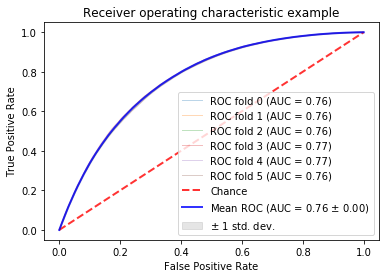

In [6]:
model, predictions = baseline_log_reg(train_X, train_Y, test_X, save_path=None) # don't save model
cross_val_roc_curve(train_X, train_Y, model)